<a href="https://colab.research.google.com/github/pboric/Capstone1/blob/main/capstone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Fatal Police Shooting in the United States

Police brutality in the United States has been a national issue since the 20th century. The public safety of U.S. citizens is a typical argument to justify the controversially high number of fatal shootings.

You are a contractor to the United States Department of Justice. You have been given a case to investigate fatal police shootings throughout the United States of America, provide a list of issues, and propose a plan on how to tackle these issues.

The department offered some tips - the public opinion indicates that there's something systematically fishy about the police actions against civilians. We also know that some states differ from the others, some cities are different from others, race equality is still an unanswered question. There's also some talk about huge spendings on police, rumors about mental issues of those getting shot. Government is all about prioritizing - use the data to list issues with the police activity and propose a plan which issues to tackle first and how.

# Structured plan of the analysis

- Data Cleaning and Feature Engineering
  - Initial Data Inspection

    Check for duplicates and remove them if any.
    Inspect data types for each feature and ensure they are appropriate for the data they represent (e.g., 'date' should be datetime type, 'age' should be float or int).

- Handling Missing Data

  Identify missing values across the dataset.
  Decide on a strategy for dealing with missing data (e.g., imputation, deletion) based on the nature of the data and the amount of missing data per feature.

- Feature Engineering

  Date-Time Features: Extract year, month, day, and weekday from the 'date' column to analyze temporal trends.

  Location Features: Combine 'city' and 'state' into a single location feature for simplicity.

  Age Group: Categorize 'age' into groups (e.g., minor, adult) for demographic analysis.


- Exploratory Data Analysis (EDA)

  - Descriptive Statistics

    Compute basic statistical measures (mean, median, mode, quartiles, variance, standard deviation) for quantitative features like age.
    For categorical data like race or gender, calculate frequency counts.

- Temporal Analysis

  Analyze trends over time (yearly, monthly) to identify any patterns or spikes in incidents.

- Demographic Analysis

  Explore the distribution of incidents by age, race, gender, and whether mental illness was related.

- Geographical Analysis

  Analyze incidents by state or region to identify areas with higher occurrences.


- Hypothesis Testing and Inference

  Formulate a hypothesis based on your EDA (e.g., there is a significant difference in the number of shootings related to mental illness over the years).
  Use statistical tests to validate these hypotheses.

- Try a machine learning model to explain relationships between features and predict new values.


- Suggestions for Further Analysis

  Suggest areas for future research, such as the impact of policy changes or training programs on the incidence of fatal shootings.

- Conclusion

  Summarize the key insights and their implications.
  Reflect on the limitations of the analysis and the data itself.


#1. Data Cleaning and Preprocessing

## 1.1. Initial Data Inspection

 Installing the necessary packages and libraries.
 Load the dataset and performing an initial exploration to understand the structure, types of data, and any immediately visible inconsistencies (missing values, incorrect data types, etc.).

In [ ]:
!pip install pygam
!pip install scikit-learn


import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from tqdm.auto import tqdm
import requests
import statsmodels.api as sm
from google.colab.data_table import DataTable
from pygam import LinearGAM, s
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv'
df = pd.read_csv(url)

# Display DataFrame information
print("Initial Data Exploration:")
display(DataTable(df.head()))  # Display only the head to avoid overwhelming the output

# Combining data types and missing values information for concise output
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
})

print("\nColumn Information:")
display(info_df)

Initial Data Exploration:


,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473



Column Information:


,Data Type,Missing Values
id,int64,0
date,object,0
threat_type,object,68
flee_status,object,1289
armed_with,object,212
city,object,71
county,object,4722
state,object,0
latitude,float64,1040
longitude,float64,1040


## 1.2. Handling Missing Data

The **date** column is of type object, which suggests it might need to be converted to datetime for time series analysis.

There are missing values in several columns, notably in **county**, **latitude**, **longitude**, **location_precision**, **race**, and **race_source**.

Removing the **county**, **race_source**, **name**, **longitude**, **latitude**, **location_precision** features features then imputing missing **ages** using the **median age**, imputing the rest of missing values with ''Unknown''.

In [ ]:
# Check the number of entries and missing values before preprocessing
num_entries_before = df.shape[0]
missing_values_before = df.isnull().sum().sum()
print(f"Number of entries before preprocessing: {num_entries_before}")
print(f"Missing values before preprocessing: {missing_values_before}")

# Remove specified columns and impute missing values
selected_columns = ['county', 'race_source', 'name', 'longitude', 'latitude', 'location_precision']
df_cleaned = df.drop(selected_columns, axis=1) \
               .fillna({'age': df['age'].median()}) \
               .fillna('Unknown')

# Summary of preprocessing steps
missing_values_after = df_cleaned.isnull().sum().sum()  # Total number of missing values
num_entries_after = df_cleaned.shape[0]  # Number of entries after preprocessing

# Elegant display of summary information
print(f"Missing values after preprocessing: {missing_values_after}")
print(f"Number of entries after preprocessing: {num_entries_after}")

Number of entries before preprocessing: 9431
Missing values before preprocessing: 12492
Missing values after preprocessing: 0
Number of entries after preprocessing: 9431


## 1.3. Feature Engineering


**Date-Time Features**: Extract year, month, day, and weekday from the 'date' column to analyze temporal trends.

**Location Features**: Combine 'city' and 'state' into a single location feature for simplicity.

**Age Group**: Categorize 'age' into groups (e.g., minor, adult) for demographic analysis.

In [ ]:
# Convert 'date' to datetime
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

# Extract year, month, day, and weekday
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['weekday'] = df_cleaned['date'].dt.weekday

# Combine 'city' and 'state' into a single location feature
df_cleaned['location'] = df_cleaned['city'] + ', ' + df_cleaned['state']

# Categorize 'age' into groups
bins = [0, 17, 64, 100]
labels = ['Minor (age<18)', 'Adult (18<age<65)', 'Senior (65<age)']
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=bins, labels=labels, right=False)

print('Date-Time and Location Features Extracted, Age Group Categorized')

- Date-time features such as year, month, day, and weekday have been successfully extracted from the 'date' column.

- Additionally, a new 'location' feature combining 'city' and 'state' has been created for simplified analysis.

- The 'age' column has been categorized into groups (Minor, Adult, Senior) to facilitate demographic analysis.

# 2. Exploratory Data Analysis (EDA)



## 2.1. Descriptive Statistics

Computing basic statistical measures (mean, median, mode, quartiles, variance, standard deviation) for quantitative features like age.

For categorical data like race or gender, calculating frequency counts.

In [ ]:
# Compute basic statistical measures for 'age'
age_descriptive_stats = df_cleaned['age'].describe()

# Calculate variance and standard deviation for 'age' (not necessary as describe() includes std)
age_variance = df_cleaned['age'].var()
age_std_dev = df_cleaned['age'].std()

# Calculate frequency counts for categorical data like 'race' and 'gender'
race_frequency = df_cleaned['race'].value_counts()
gender_frequency = df_cleaned['gender'].value_counts()

# Display results more elegantly
print(f"Descriptive Statistics for Age:\n{age_descriptive_stats}\n")
print(f"Variance of Age: {age_variance}\nStandard Deviation of Age: {age_std_dev}\n")
print(f"Frequency Counts for Race:\n{race_frequency}\n")
print(f"Frequency Counts for Gender:\n{gender_frequency}\n")

Descriptive Statistics for Age:
count    9431.000000
mean       37.320433
std        12.689362
min         2.000000
25%        28.000000
50%        35.000000
75%        45.000000
max        92.000000
Name: age, dtype: float64

Variance of Age: 161.01989953710788
Standard Deviation of Age: 12.689361667834513

Frequency Counts for Race:
W          4233
B          2220
H          1518
Unknown    1135
A           165
N           126
O            29
W;B;N         1
N;H           1
W;H           1
B;H           1
W;B           1
Name: race, dtype: int64

Frequency Counts for Gender:
male          8987
female         414
Unknown         29
non-binary       1
Name: gender, dtype: int64



## 2.2. Temporal Analysis

Analyzing trends over time (yearly, monthly) to identify any patterns or spikes in incidents.

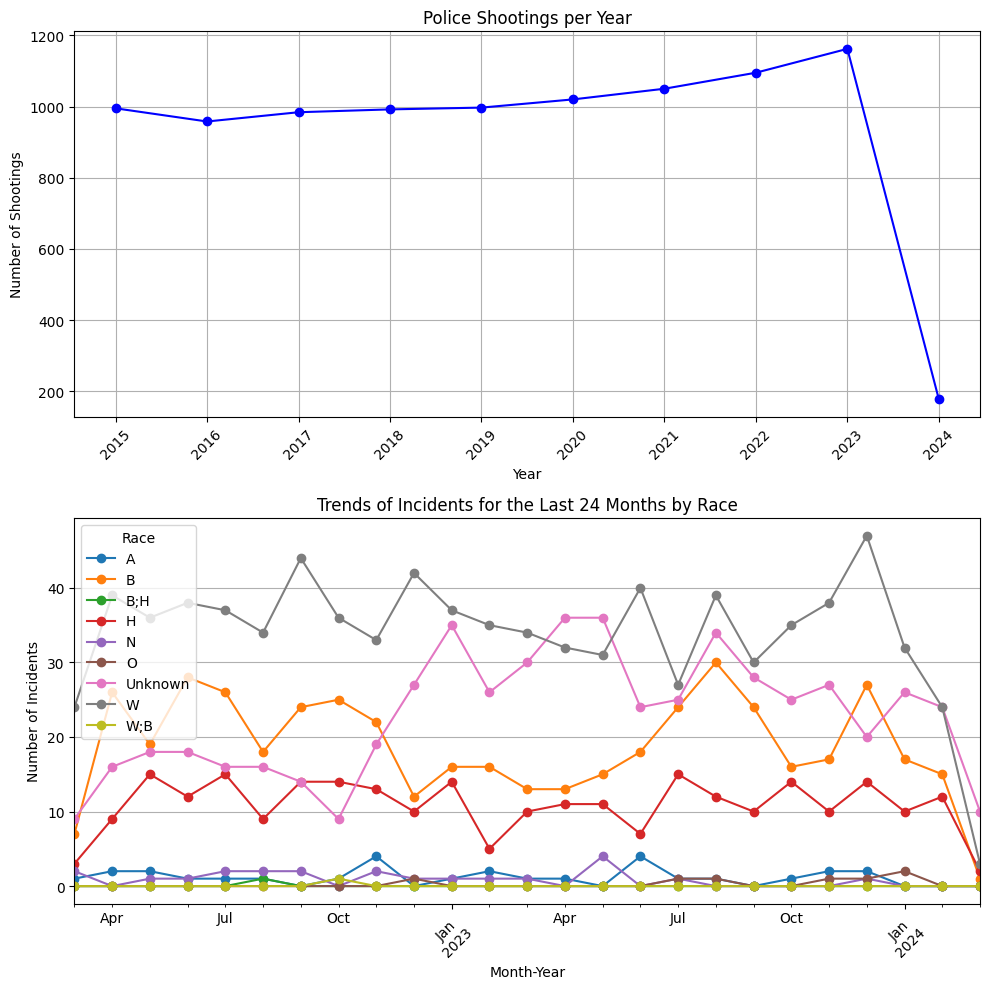

In [ ]:
# Count the number of shootings per year
shootings_per_year = df_cleaned.groupby('year').size()

# Filter the data for the last 24 months
last_24_months = df_cleaned[df_cleaned['date'] >= pd.Timestamp.now() - pd.DateOffset(months=24)]

# Group by race and date (month-year) and count incidents
incidents_by_race_month = last_24_months.groupby([last_24_months['race'], last_24_months['date'].dt.to_period('M')]).size().unstack(fill_value=0)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Rows, 1 Column

# Plot the first plot (Police Shootings per Year) on the first subplot
axs[0].plot(shootings_per_year.index, shootings_per_year.values, marker='o', linestyle='-', color='b')
axs[0].set_title('Police Shootings per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Shootings')
axs[0].grid(True)
axs[0].set_xticks(shootings_per_year.index)
axs[0].tick_params(axis='x', rotation=45)

# Plot the second plot (Trends of Incidents for the Last 24 Months by Race) on the second subplot
incidents_by_race_month.T.plot(ax=axs[1], marker='o')  # Use the ax parameter to specify the subplot
axs[1].set_title('Trends of Incidents for the Last 24 Months by Race')
axs[1].set_xlabel('Month-Year')
axs[1].set_ylabel('Number of Incidents')
axs[1].legend(title='Race')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

- The first graph illustrates the trend of police shootings per year. From 2015 to 2020, the number of police shootings is sligthly increasing during the years. However, this should be further investigated.

- The second graph displays the trends of incidents for the last 24 months by race. Different colored lines represent various racial groups. There is no clear pattern of consistent increase or decrease for any specific group over this period.

Further research and context would be necessary to draw meaningful insights.

## 2.3. Demographic Analysis

Exploring the distribution of incidents by age, race, gender, whether mental illness was related and the correlation of the race, armed status and the number of incidents.

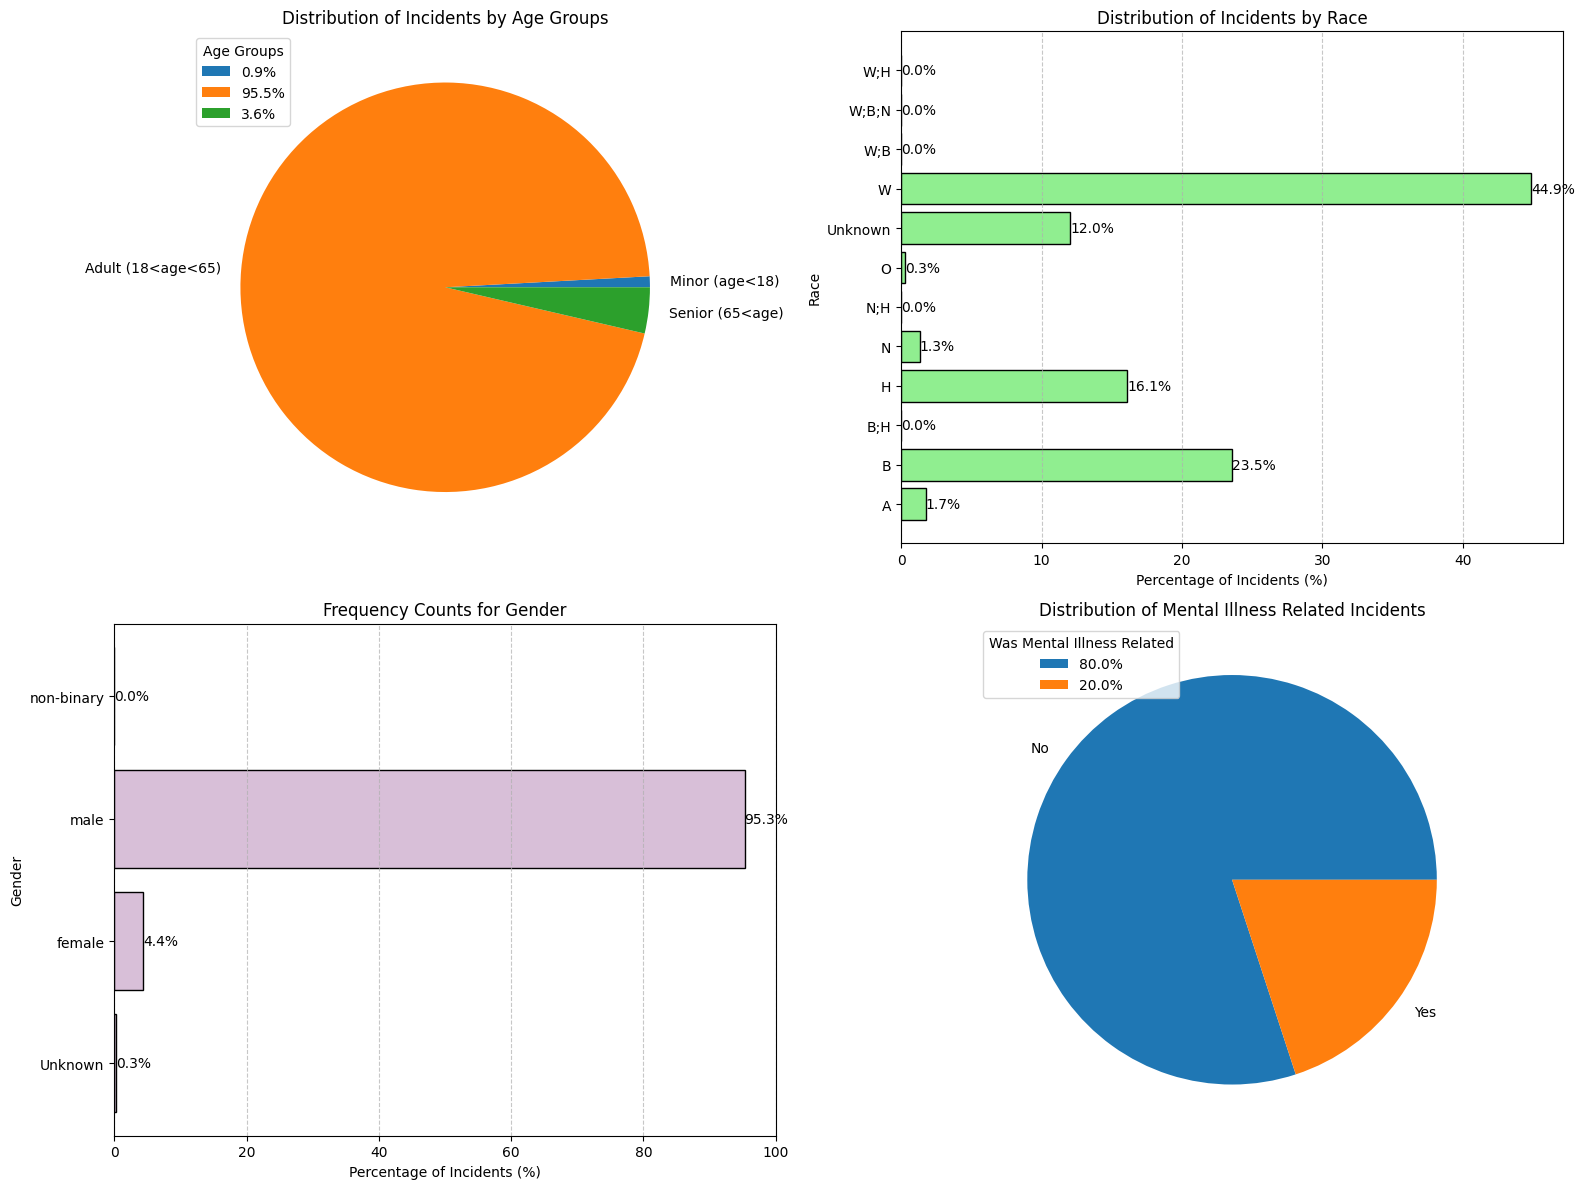

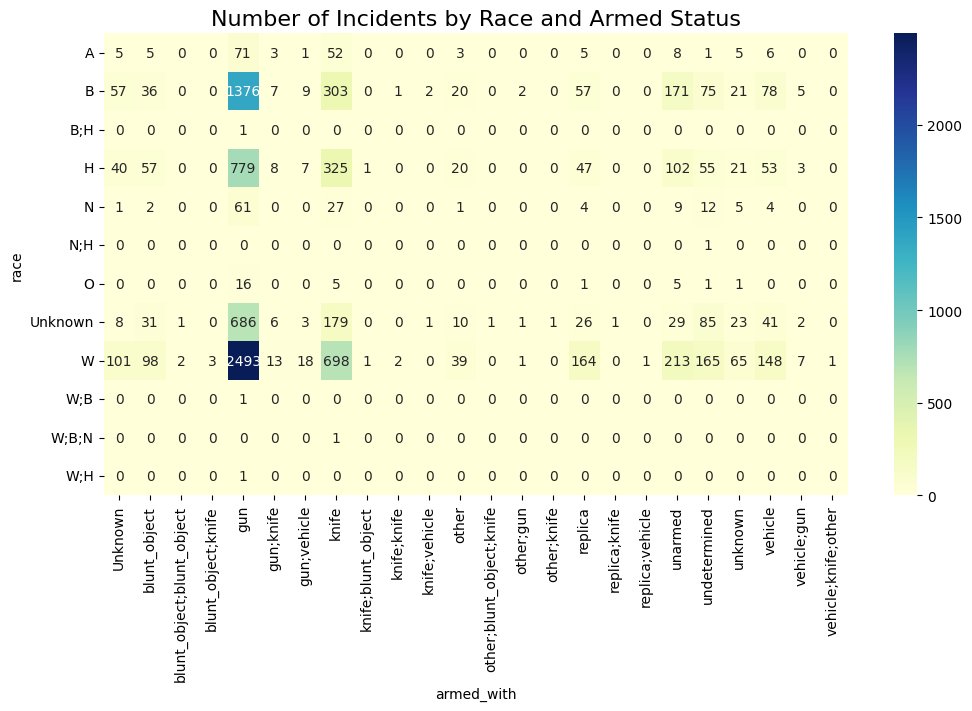

In [ ]:
# Prepare the data for the heatmap
count_by_race_armed = df_cleaned.groupby(['race', 'armed_with']).size().unstack(fill_value=0)

# Main figure for individual plots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

total_incidents = df_cleaned.shape[0]

# Plot 1: Distribution of Incidents by Age Groups
age_group_counts = df_cleaned['age_group'].value_counts().sort_index() / total_incidents * 100
axs[0, 0].pie(age_group_counts.values, labels=age_group_counts.index, autopct='', pctdistance=1.2)
axs[0, 0].legend(title='Age Groups', loc='upper left', labels=['%1.1f%%' % i for i in age_group_counts.values])
axs[0, 0].set_title('Distribution of Incidents by Age Groups')

# Plot 2: Distribution of Incidents by Race
race_counts = df_cleaned['race'].value_counts().sort_index() / total_incidents * 100
bars = axs[0, 1].barh(race_counts.index, race_counts.values, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Distribution of Incidents by Race')
axs[0, 1].set_xlabel('Percentage of Incidents (%)')
axs[0, 1].set_ylabel('Race')
axs[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    axs[0, 1].text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')

# Plot 3: Distribution of Incidents by Gender
gender_counts = df_cleaned['gender'].value_counts().sort_index() / total_incidents * 100
bars = axs[1, 0].barh(gender_counts.index, gender_counts.values, color='thistle', edgecolor='black')
axs[1, 0].set_title('Frequency Counts for Gender')
axs[1, 0].set_xlabel('Percentage of Incidents (%)')
axs[1, 0].set_ylabel('Gender')
axs[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    axs[1, 0].text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')

# Plot 4: Distribution of Mental Illness Relatedness
mental_illness_counts = df_cleaned['was_mental_illness_related'].value_counts().sort_index() / total_incidents * 100
axs[1, 1].pie(mental_illness_counts.values, labels=['No', 'Yes'], autopct='', pctdistance=1.2)
axs[1, 1].legend(title='Was Mental Illness Related', loc='upper left', labels=['%1.1f%%' % i for i in mental_illness_counts.values])
axs[1, 1].set_title('Distribution of Mental Illness Related Incidents')

plt.tight_layout()

# Separate figure for the heatmap
fig2, ax2 = plt.subplots(figsize=(12, 6))
sns.heatmap(count_by_race_armed, annot=True, fmt="d", cmap="YlGnBu", ax=ax2)
ax2.set_title('Number of Incidents by Race and Armed Status', fontdict={'fontsize': 16}, loc='center');


- First pie chart indicates that the most of the victims (95.5%) are adults (18-65 years).
- Distribution of Incidents by Race plot indicates that white victims are most prominent (44.8%). After white victims, black victims are following (23.5%)
- Frequency Counts for Gender indicates that male victims are most often killed (95.3%)
- Distribution of Mental Illness Related Incidents indicates that 20% of victims have a mental illnes.
- The heatmap shows us the correlation between the weapon that the victim had, the race and the number of incidents. Most of the victims had a gun and the black race is more inclined to use a gun.

## 2.4. Geographical Analysis

Analyze incidents by state or region to identify areas with higher occurrences.

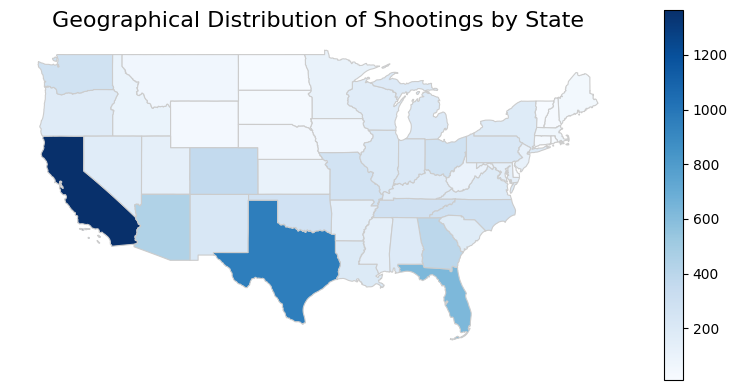

In [ ]:
tqdm.pandas()

# Load the dataset 2
url = 'https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-agencies.csv'
df_agencies = pd.read_csv(url)

# Summarize total shootings by state
state_counts = df_agencies.groupby('state')['total_shootings'].sum().reset_index()
state_counts.columns = ['state', 'incidents']

# Load US map
us_map = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')

# Merge the counts with the map
us_map = us_map.merge(state_counts, how='left', left_on='STUSPS', right_on='state')

# Exclude Alaska and Hawaii for visualization purposes
us_map = us_map.loc[~us_map['STUSPS'].isin(['AK', 'HI'])]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # Adjusted figure size for a larger map

us_map.plot(column='incidents', ax=ax, cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Geographical Distribution of Shootings by State', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.savefig('geographical_distribution_of_shootings_by_state.png', dpi=300)
plt.show()

- California has the highest number of incidents, Texas and Florida are following behind.

# 3. Hypothesis Testing and Inference

Hypotheses based on the EDA and statistical tests to validate them.

## 3.1. Hypothesis: The number of police shootings has increased over the years.
Generalized Additive Model (GAM) with independent variable as ‘Months Since Start’ and dependent variable as ‘Number of Shootings’.

Statistical test: Wald test statistic for each coefficient (smooth term). Convert the test statistic to a two-tailed p-value using the cumulative distribution function (CDF) of the standard normal distribution.
Print the p-values for each spline term.

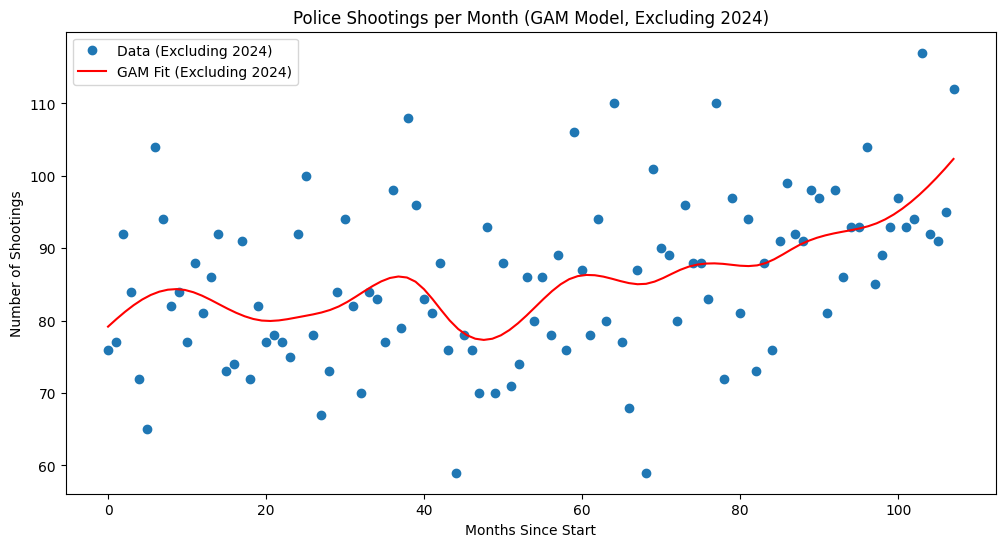

Spline term 1 p-value: 0.3969
Spline term 2 p-value: 0.4621


In [ ]:
# Extract year and month for grouping, then exclude data from the year 2024
df_filtered = df_cleaned[df_cleaned['date'].dt.year != 2024]

# Count the number of shootings per month, excluding 2024
shootings_per_month_filtered = df_filtered.groupby(df_filtered['date'].dt.to_period('M')).size()

# Convert PeriodIndex to datetime index to perform calculations, excluding 2024
shootings_per_month_filtered.index = shootings_per_month_filtered.index.to_timestamp()

# Calculate the number of months since the start of the dataset, excluding 2024
start_date_filtered = shootings_per_month_filtered.index.min()
X_filtered = ((shootings_per_month_filtered.index - start_date_filtered) / np.timedelta64(1, 'M')).values.reshape(-1, 1)
y_filtered = shootings_per_month_filtered.values

# Fit the GAM model with a spline for the month, excluding 2024
gam_filtered = LinearGAM(s(0, n_splines=25)).fit(X_filtered, y_filtered)

# Generate predictions for a smooth curve, excluding 2024
X_pred_filtered = np.linspace(X_filtered.min(), X_filtered.max(), 100).reshape(-1, 1)
y_pred_filtered = gam_filtered.predict(X_pred_filtered)

# Plotting the original data (excluding 2024) and the GAM fit
plt.figure(figsize=(12, 6))
plt.plot(X_filtered, y_filtered, 'o', label='Data (Excluding 2024)')
plt.plot(X_pred_filtered, y_pred_filtered, label='GAM Fit (Excluding 2024)', color='red')
plt.title('Police Shootings per Month (GAM Model, Excluding 2024)')
plt.xlabel('Months Since Start')
plt.ylabel('Number of Shootings')
plt.legend()
plt.show()

# Get the estimated coefficients and their standard errors
coefficients = gam_filtered.coef_
standard_errors = np.sqrt(np.diag(gam_filtered.statistics_['cov']))

# Calculate the Wald test statistic for each coefficient
wald_test_statistic = coefficients / standard_errors

# Calculate the p-values using the cumulative distribution function (CDF) of the standard normal distribution
p_values = 2 * (1 - norm.cdf(np.abs(wald_test_statistic)))

# Print the results
for i, term in enumerate(gam_filtered.terms):
    print(f"Spline term {i+1} p-value: {p_values[i]:.4f}")

Spline Term 1:
The p-value for the first spline term is 0.3969.
This p-value indicates that the first spline term is not statistically significant at the conventional significance level (e.g., α = 0.05).
In other words, there is insufficient evidence to reject the null hypothesis that the coefficient for the first spline term is zero.

Spline Term 2:
The p-value for the second spline term is 0.4621.
Similarly, this p-value suggests that the second spline term is also not statistically significant.
Again, we fail to reject the null hypothesis that the coefficient for the second spline term is zero.

Given these p-values, it appears that neither of the spline terms significantly contributes to explaining the variation in the number of shootings per month in the model. Alternative modeling approaches or exploring additional features to improve the model’s fit should be considered. 📊🔍

# 4. Predictive analysis:

## 4.1 Predict the number of police shootings for the year 2024 using Random Forest model

In [ ]:
# Ensuring grouping by both 'year' and 'month' and count the occurrences
shootings_per_month = df_cleaned.groupby(['year', 'month']).size().reset_index(name='shootings')

# Use data up to 2023 for training
train_data = shootings_per_month[shootings_per_month['year'] < 2024]

# Prepare features X and target y from the training data
X_train = train_data[['year', 'month']]
y_train = train_data['shootings']

# Instantiate and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Preparing the feature matrix for 2024
X_2024 = pd.DataFrame({
    'year': [2024]*12,  # Repeat 2024 for all 12 months
    'month': list(range(1, 13))  # Months from 1 to 12
})

# Predict the number of shootings for each month in 2024
y_2024_pred = model.predict(X_2024)

# Summing up the predicted shootings for each month to get the total for the year 2024
total_shootings_2024 = np.sum(y_2024_pred)

print(f"Predicted total number of police shootings for the year 2024: {total_shootings_2024}")

Predicted total number of police shootings for the year 2024: 1145.93


# Suggestions for Further Analysis

- Further explore temporal patterns with more granularity or through different lenses, such as examining the effects of specific events or legislation changes on police shootings trends.


- Deepen the demographic analysis by considering intersectionality, for example, looking at race and age together, or examining gender differences within racial groups to uncover more nuanced insights.


- Conduct additional hypothesis tests to explore other interesting hypotheses generated from your EDA. For example, test if there's a significant difference in the number of shootings across different regions or states.


- Beyond Random Forest, experiment with other models and compare their performance to find the best predictive model for the data.


# Conclusion

The number of incidents is getting higher each year.


Most of the victims are white and armed with a gun.

Black victims have guns with them more often than other races.

California has the highest number of incidents, next is Texas and Florida.
